In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder, OneHotCategoricalEncoder
from feature_engine import variable_transformers as vt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [12]:
raw_data = pd.read_csv('Data/house_data_details_cleaned.csv')
df = raw_data.copy()

In [13]:
#profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
#profile.to_file("RealEstateAVM_ProfileReport.html")

In [14]:
df.head()

,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,realtyID,county,subdivision,census,tract,lot,zoning,date,sale_price,estimated_value,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,url,bedrooms,bathrooms
0,33.97462,-118.13368,6224 Nye St,Condominium,1357.00000,22215.60000,1988.00000,6357012043,1111054477.00000,Los Angeles,45351,1.00000,532304.00000,1,CMR3,9/28/20,469000.00000,439000.00000,7,High,15,1,Average,https://www.realtytrac.com/property/ca/commerc...,3.00000,3.00000
1,34.15656,-118.39689,4723 Laurel Canyon Blvd,Restaurant,2250.00000,9799.00000,1959.00000,2356037034,1111055289.00000,Los Angeles,7360,1.00000,143400.00000,10,LAC2,9/28/20,1910000.00000,nan,5,NaN,6,1,Excellent,https://www.realtytrac.com/property/ca/valley-...,nan,nan
2,34.67778,-118.45116,18118 Elizabeth Lake Rd,Apartment house (5+ units),1454.00000,13635.00000,1948.00000,3242015023,1111055911.00000,Los Angeles,NaN,2.00000,920102.00000,4,LCC4*,9/28/20,325000.00000,nan,0,NaN,2,1,NaN,https://www.realtytrac.com/property/ca/lake-hu...,7.00000,6.00000
3,34.07296,-118.06690,9259 Ramona Blvd,Single Family Residence,1682.00000,7000.00000,1978.00000,8594027016,1111055994.00000,Los Angeles,ROSEMEAD,2.00000,432901.00000,6,RMPOD*,9/28/20,738000.00000,752000.00000,3,Moderate,11,1,Excellent,https://www.realtytrac.com/property/ca/rosemea...,3.00000,2.00000
4,33.77772,-118.15491,825 Obispo Ave,"Triplex (3 units, any combination)",1958.00000,6754.00000,1938.00000,7258013016,1111056010.00000,Los Angeles,1,2.00000,576904.00000,18,LBR2N,9/28/20,1185000.00000,989000.00000,11,Slightly High,8,1,Average,https://www.realtytrac.com/property/ca/long-be...,4.00000,3.00000


In [15]:
df.describe()

,latitude,longitude,home_size,lot_size,year_built,parcel_number,realtyID,census,tract,sale_price,estimated_value,sex_offenders,enviornmental_hazards,natural_disasters,bedrooms,bathrooms
count,6316.00000,6316.00000,6080.00000,6298.00000,6118.00000,6392.00000,6388.00000,6320.00000,6320.00000,6172.00000,5829.00000,6392.00000,6392.00000,6392.00000,5846.00000,5846.00000
mean,34.11073,-118.26998,2413.91036,42387.96885,1963.96404,5034101203.97935,1111177566.99765,2.02532,445496.43228,1108722.00745,883497.70115,7.53207,6.97434,1.20291,3.44389,2.69004
std,0.22492,0.21371,6253.24258,236368.51727,26.23880,2112257388.20188,247218.52189,1.12109,258571.06364,1974912.09696,522913.62934,13.13463,6.89059,0.43184,3.27886,3.10634
min,33.33958,-118.88275,3.00000,283.00000,1883.00000,2004009012.00000,1110722482.00000,1.00000,0.00000,500.00000,104000.00000,0.00000,1.00000,0.00000,1.00000,1.00000
25%,33.96935,-118.42553,1230.75000,6007.00000,1948.00000,3004016533.75000,1110958138.75000,1.00000,216200.00000,499000.00000,545000.00000,1.00000,3.00000,1.00000,2.00000,2.00000
50%,34.08752,-118.29199,1626.00000,7659.50000,1961.00000,5082027012.50000,1111203790.50000,2.00000,408705.50000,706500.00000,712000.00000,4.00000,5.00000,1.00000,3.00000,2.00000
75%,34.18874,-118.12871,2302.25000,17275.50000,1984.00000,7138272516.25000,1111393573.75000,3.00000,602002.50000,1115000.00000,1050000.00000,9.00000,8.00000,1.00000,4.00000,3.00000
max,34.81875,-117.61020,295336.80000,12486474.00000,2020.00000,8765016012.00000,1112033176.00000,8.00000,980008.00000,75454545.00000,2998000.00000,135.00000,91.00000,3.00000,96.00000,99.00000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   latitude               6316 non-null   float64
 1   longitude              6316 non-null   float64
 2   address                6381 non-null   object 
 3   property_type          6392 non-null   object 
 4   home_size              6080 non-null   float64
 5   lot_size               6298 non-null   float64
 6   year_built             6118 non-null   float64
 7   parcel_number          6392 non-null   int64  
 8   realtyID               6388 non-null   float64
 9   county                 6392 non-null   object 
 10  subdivision            5895 non-null   object 
 11  census                 6320 non-null   float64
 12  tract                  6320 non-null   float64
 13  lot                    5984 non-null   object 
 14  zoning                 6392 non-null   object 
 15  date

In [17]:
#Remove missing values for the target feature
df.dropna(inplace=True)
print(f'Number of observations before removing missing values: {raw_data.shape[0]}')
print(f'Number of observations after removing missing values: {df.shape[0]}')

Number of observations before removing missing values: 6392
Number of observations after removing missing values: 4269


In [18]:
#Convert date into a datetime object
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df['date']

0      2069-09-19
1      2069-07-01
2      2069-04-23
3      2069-01-22
4      2067-12-13
          ...    
4264   1970-11-23
4265   1970-10-06
4266   1970-09-22
4267   1970-08-14
4268   1970-02-10
Name: date, Length: 4269, dtype: datetime64[ns]

In [19]:
#Correct the dates
df['date'] = df['date'].apply(lambda x: x.replace(year= x.year-100) if x.year>2020 else x)
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df['date']

0      2020-10-09
1      2020-10-09
2      2020-10-09
3      2020-10-09
4      2020-10-09
          ...    
4264   1967-12-13
4265   1966-11-29
4266   1965-01-11
4267   1964-12-18
4268   1964-07-02
Name: date, Length: 4269, dtype: datetime64[ns]

In [20]:
#Add a month/year, year, and month column
df['month_year'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.to_period('Y')
df['month'] = df['date'].dt.month
df[['month_year','year', 'month']]

,month_year,year,month
0,2020-10,2020,10
1,2020-10,2020,10
2,2020-10,2020,10
3,2020-10,2020,10
4,2020-10,2020,10
...,...,...,...
4264,1967-12,1967,12
4265,1966-11,1966,11
4266,1965-01,1965,1
4267,1964-12,1964,12


In [21]:
#We need to adjust the prices based on inflation
#Add a new column that will be used for the merge
df['observation_date'] = df['date'].values.astype('datetime64[M]')

#Read in a file with consumer price index
cpi_df = pd.read_csv('CPIAUCNS.csv')
cpi_df['observation_date'] = pd.to_datetime(cpi_df['observation_date'])
#cpi_df['observation_date'] = cpi_df['observation_date'].apply(lambda x: x.replace(year= x.year-200) if x.year>2020 else x)
cpi_df.sort_values(by='observation_date', ascending=False, inplace=True, ignore_index=True)

merged_df = pd.merge(df, cpi_df, on='observation_date', how='left')
merged_df = merged_df.drop_duplicates()
merged_df.rename(columns={'CPIAUCNS':'cpi'}, inplace=True)
print(merged_df.shape)
merged_df[:5]

(4269, 31)


,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,realtyID,county,subdivision,census,tract,lot,zoning,date,sale_price,estimated_value,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,url,bedrooms,bathrooms,month_year,year,month,observation_date,cpi
0,34.55059,-118.08269,2545 Apache Plume Ct,Single Family Residence,1422.00000,5169.00000,1981.00000,3053036419,1111557769.00000,Los Angeles,39323,2.00000,910716.00000,108,PDRPD10U*,2020-10-09,305000.00000,330200.00000,6,Moderate,2,1,Average,https://www.realtytrac.com/property/ca/palmdal...,3.00000,2.00000,2020-10,2020,10,2020-10-01,260.28000
1,33.99501,-118.04730,12133 Beverly Dr,Single Family Residence,1805.00000,7133.00000,1930.00000,8126015017,1111549466.00000,Los Angeles,4993,1.00000,501501.00000,53,WHR1YY,2020-10-09,722000.00000,717900.00000,4,Moderate,3,1,Average,https://www.realtytrac.com/property/ca/whittie...,2.00000,2.00000,2020-10,2020,10,2020-10-01,260.28000
2,34.07099,-117.99388,12844 Waltham St,Single Family Residence,1080.00000,12251.00000,1947.00000,8556005010,1111564332.00000,Los Angeles,10104,3.00000,404701.00000,283,BPR1*,2020-10-09,480000.00000,558900.00000,4,Moderate,3,1,Average,https://www.realtytrac.com/property/ca/baldwin...,3.00000,1.00000,2020-10,2020,10,2020-10-01,260.28000
3,34.50503,-118.54434,30315 Quail Trl,Single Family Residence,2794.00000,352836.00000,2001.00000,3244083018,1111564264.00000,Los Angeles,PARCEL MAP 20057,3.00000,920102.00000,3,LCA22*,2020-10-09,950000.00000,1783000.00000,0,Low,3,2,Excellent,https://www.realtytrac.com/property/ca/santa-c...,4.00000,3.00000,2020-10,2020,10,2020-10-01,260.28000
4,34.70168,-118.16062,45047 Lorimer Ave,Single Family Residence,1382.00000,8268.00000,1955.00000,3121029013,1111552029.00000,Los Angeles,18604,1.00000,900805.00000,13,LRRA7000*,2020-10-09,231500.00000,269300.00000,4,Moderate,2,1,Average,https://www.realtytrac.com/property/ca/lancast...,4.00000,2.00000,2020-10,2020,10,2020-10-01,260.28000


In [23]:
merged_df['cpi_multiplier'] = merged_df['cpi'].iloc[0] / merged_df['cpi']
#merged_df['sale_price'] = merged_df['cpi_multiplier'] * merged_df['sale_price']

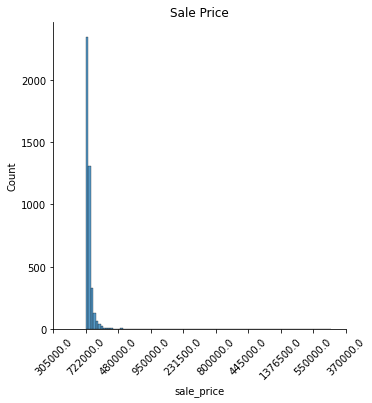

In [24]:
#Plot the sale_price distribution
chart = sns.displot(merged_df['sale_price'], bins=100)
plt.title('Sale Price')
plt.ticklabel_format(style='plain', axis='x')
chart.set(xticklabels=df['sale_price'])
chart.set_xticklabels(rotation=45);

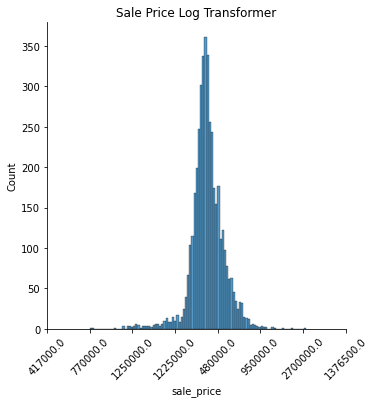

In [186]:
#Use a Log Transformer
lt = vt.LogTransformer(variables = ['sale_price'])
lt.fit(merged_df)

df_trimmed = lt.transform(merged_df)

chart = sns.displot(temp['sale_price'], bins=100)
plt.title('Sale Price Log Transformer')
plt.ticklabel_format(style='plain', axis='x')
chart.set(xticklabels=merged_df['sale_price'])
chart.set_xticklabels(rotation=45);

The sale price upper boundary is 1985000.0
Number of observations before removing outliers: 4269
Number of observations after removing outliers: 3902


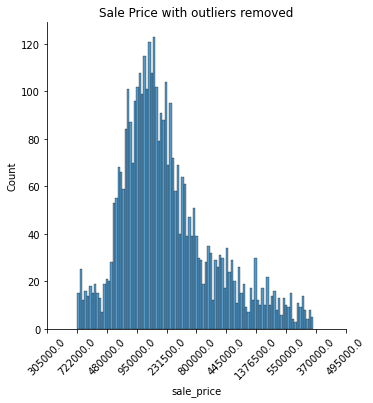

In [25]:
#This function will identify the outlier boundaries for a variable

def find_skewed_boundaries(df, var, distance):
    
    IQR = df['sale_price'].quantile(.75) - df['sale_price'].quantile(.25)
    
    lower_boundary = df['sale_price'].quantile(.25) - (distance*IQR)
    upper_boundary = df['sale_price'].quantile(.75) + (distance*IQR)
    
    return upper_boundary, lower_boundary


sales_upper_boundary, sales_lower_boundary = find_skewed_boundaries(merged_df, 'sale_price', 1.5)
print(f'The sale price upper boundary is {sales_upper_boundary}')

#Remove outlier values
df_trimmed = merged_df.loc[merged_df['sale_price']<sales_upper_boundary,:]
print(f'Number of observations before removing outliers: {merged_df.shape[0]}')
print(f'Number of observations after removing outliers: {df_trimmed.shape[0]}')

chart = sns.displot(df_trimmed['sale_price'], bins=100)
plt.title('Sale Price with outliers removed')
plt.ticklabel_format(style='plain', axis='x')
chart.set(xticklabels=df_trimmed['sale_price'])
chart.set_xticklabels(rotation=45);

### Variable Transformers

In [41]:
#Log Transformer
lt = vt.LogTransformer(variables = ['sale_price'])
lt.fit(df_trimmed)

temp = lt.transform(df_trimmed)

#Recirprocal Transformer
rt = vt.ReciprocalTransformer(variables = ['sale_price'])
rt.fit(df_trimmed)

temp = rt.transform(df_trimmed)

#Power Transformer
et = vt.PowerTransformer(variables = ['sale_price'])
et.fit(df_trimmed)

temp = et.transform(df_trimmed)

#Box Cox Transformer
bct = vt.BoxCoxTransformer(variables = ['sale_price'])
bct.fit(df_trimmed)

temp = bct.transform(df_trimmed)

#Yeo Johnson Transformer
yjt = vt.YeoJohnsonTransformer(variables = ['sale_price'])
yjt.fit(df_trimmed)

temp = bct.transform(df_trimmed)

In [26]:
#Remove any houses in Catalina Island as they can be considered outliers
print(f'Number of observations before removing outliers: {df_trimmed.shape[0]}')
df_trimmed = df_trimmed.loc[df['latitude']>33.6,:]
print(f'Number of observations after removing outliers: {df_trimmed.shape[0]}')

Number of observations before removing outliers: 3902
Number of observations after removing outliers: 3898


In [27]:
#Examine the property type feature
temp = pd.concat([df_trimmed.groupby('property_type')['sale_price'].mean(), df_trimmed.groupby('property_type')['sale_price'].count(), df['property_type'].value_counts(normalize=True)], axis=1)
temp.columns = ['Average sale price', 'Count of property_type', 'Percentage of property type']
temp.sort_values(by=['Count of property_type'], axis=0,ascending=False, inplace=True)
print(f'Number of categories for property_type: {df_trimmed.property_type.nunique()}')
temp

Number of categories for property_type: 11


,Average sale price,Count of property_type,Percentage of property type
Single Family Residence,772465.20272,2792,0.72125
Condominium,642174.60305,655,0.15601
"Duplex (2 units, any combination)",776282.20238,168,0.04193
Planned Unit Development (PUD),717112.31884,138,0.03303
"Triplex (3 units, any combination)",838703.70370,54,0.01593
Apartment house (5+ units),1178564.48837,43,0.01804
"Quadplex (4 Units, Any Combination)",1006952.38095,42,0.01171
Mobile home,422500.00000,2,0.00047
Residential - Vacant Land,1004000.00000,2,0.00117
MISCELLANEOUS (Commercial),675000.00000,1,0.00023


In [28]:
#Remove the infrequent property types
infrequent_prop_types = ['MISCELLANEOUS   (Commercial)', 'Religious, Church, Worship (Synagogue, Temple, Parsonage)', 'Residential - Vacant Land', 'Mobile home']
print(f'Number of observations before removing infrequent property types: {df_trimmed.shape[0]}')

for col in infrequent_prop_types:
    indexNames = df_trimmed[(df_trimmed['property_type']==col)].index
    df_trimmed.drop(indexNames, inplace=True)
    

print(f'Number of observations after removing infrequent property types: {df_trimmed.shape[0]}')

Number of observations before removing infrequent property types: 3898
Number of observations after removing infrequent property types: 3892


In [34]:
temp = pd.concat([df_trimmed.groupby('property_type')['sale_price'].mean(), df_trimmed.groupby('property_type')['sale_price'].count(), df_trimmed['property_type'].value_counts(normalize=True)], axis=1)
temp.columns = ['Average sale price', 'Count of property_type', 'Percentage of property type']
temp.sort_values(by=['Average sale price'], axis=0,ascending=False, inplace=True)
print(f'Number of categories for property_type: {df_trimmed.property_type.nunique()}')
temp

Number of categories for property_type: 7


,Average sale price,Count of property_type,Percentage of property type
Apartment house (5+ units),1178564.48837,43,0.01105
"Quadplex (4 Units, Any Combination)",1006952.38095,42,0.01079
"Triplex (3 units, any combination)",838703.70370,54,0.01387
"Duplex (2 units, any combination)",776282.20238,168,0.04317
Single Family Residence,772465.20272,2792,0.71737
Planned Unit Development (PUD),717112.31884,138,0.03546
Condominium,642174.60305,655,0.16829


In [30]:
#Examine sale price as a function of time for each property type

def property_type_plot(df, var):
    
    categories = list(df[var].unique())
    df['month'] = df['month'].astype(str)
    df_copy = df.copy()
    
    for cat in categories:
        df = df_copy.loc[df_copy[var]==cat, :]
        if df.shape[0]>40:
            df.groupby('month')['sale_price'].mean().reset_index().sort_values('month').plot(figsize=(12,8))
            plt.ticklabel_format(style='plain', axis='y')
            #plt.xlim('2015-01', df['month'].max())
            plt.ylim(df['sale_price'].min(), 4000000)
            plt.title(f'Average Sale Price by Month for {cat}')
            plt.show();
        else:
            continue

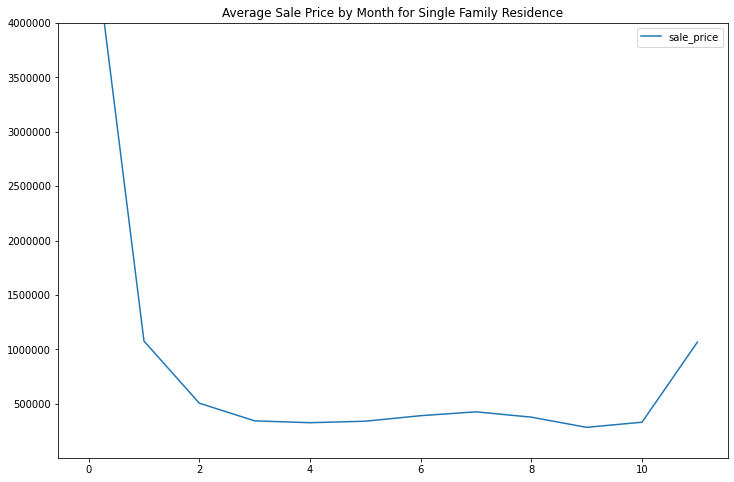

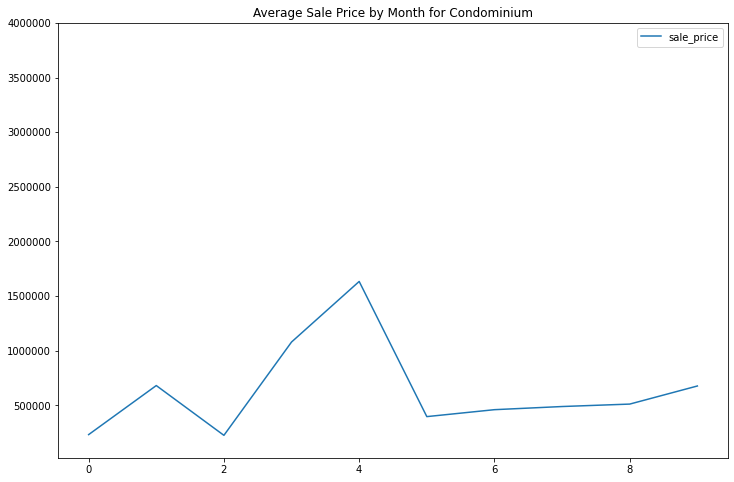

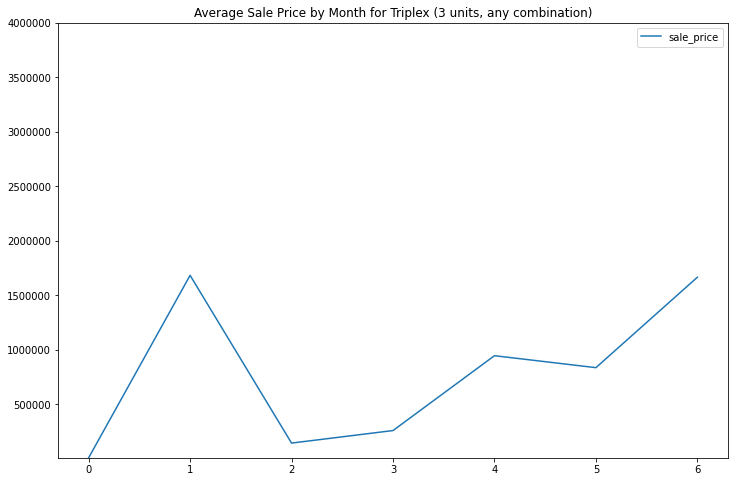

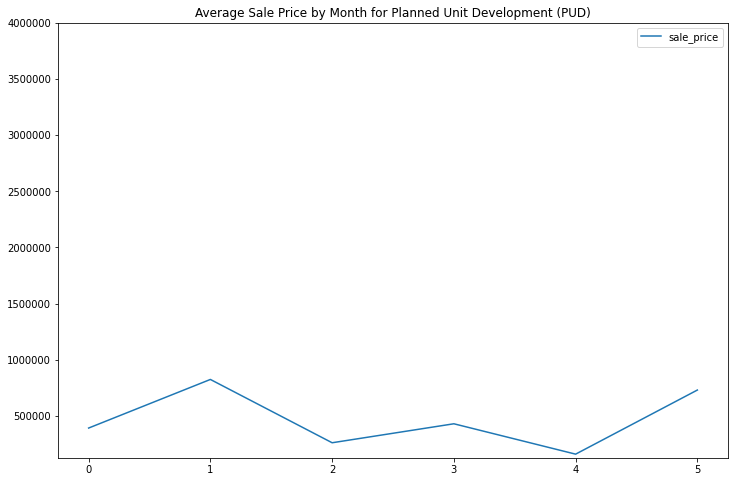

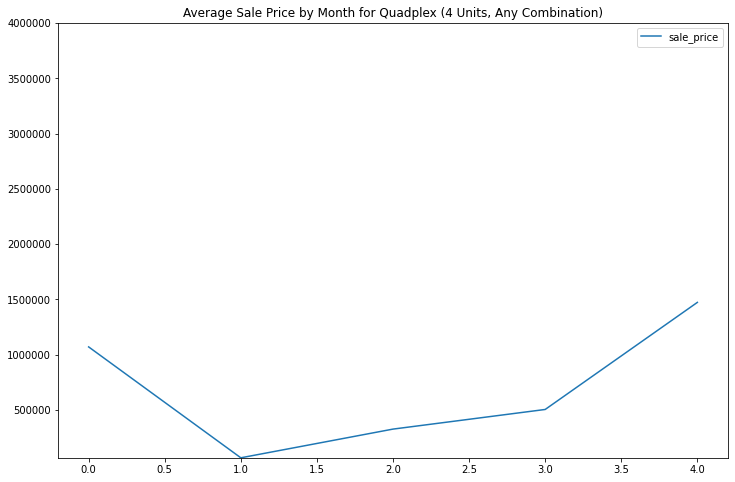

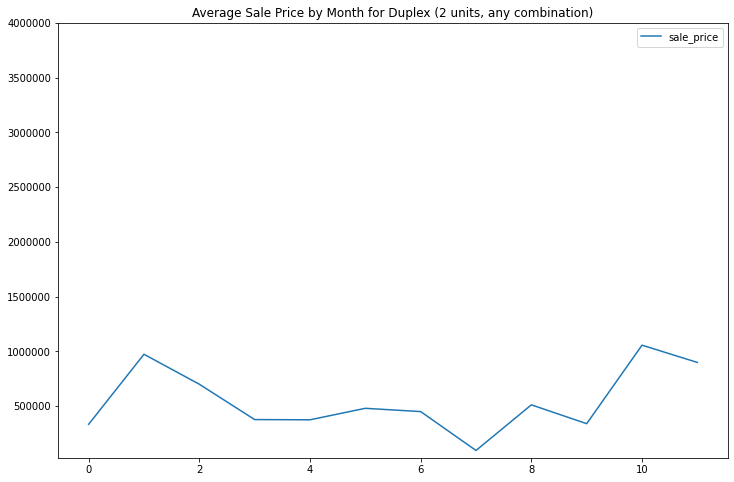

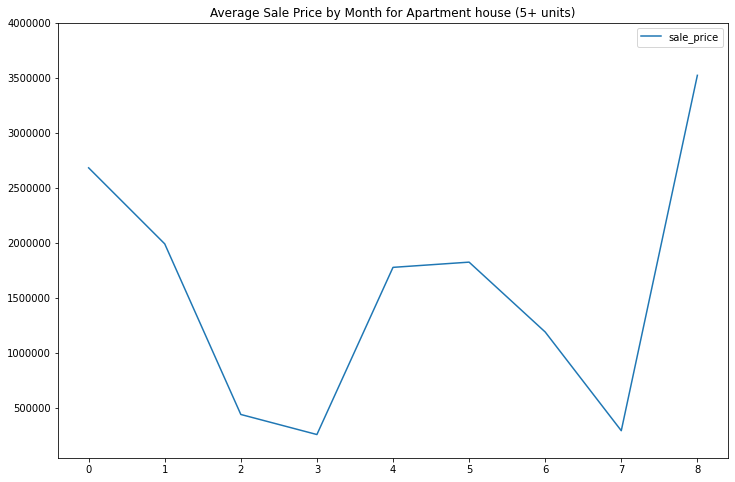

In [191]:
property_type_plot(df, 'property_type')

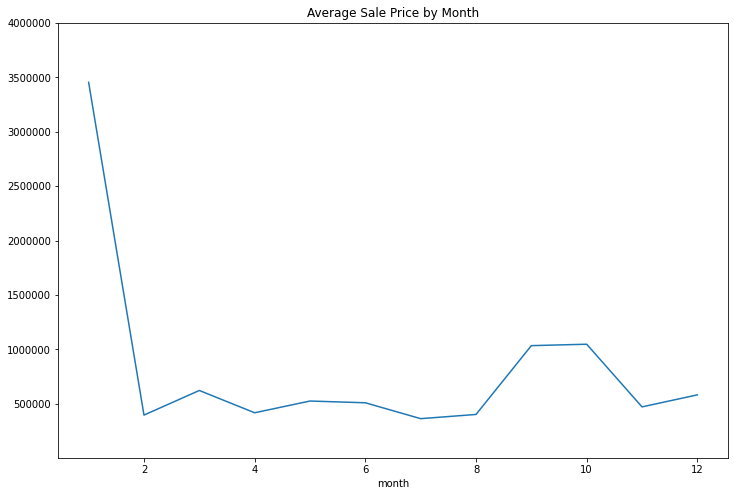

In [32]:
#Examine the trend of saleprice by month
df.groupby('month')['sale_price'].mean().plot(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(df['sale_price'].min(), 4000000)
plt.title('Average Sale Price by Month');

In [33]:
df['month'].value_counts()

9     2197
10    1810
8       40
12      32
7       31
6       26
4       26
5       25
11      23
3       23
1       23
2       13
Name: month, dtype: int64

In [17]:
ohe_encoder = OneHotCategoricalEncoder(top_categories=7,
                                       variables=['property_type', 'crime_index', 'school_quality'])

ohe_encoder.fit(df_trimmed)

temp = ohe_encoder.transform(df_trimmed)

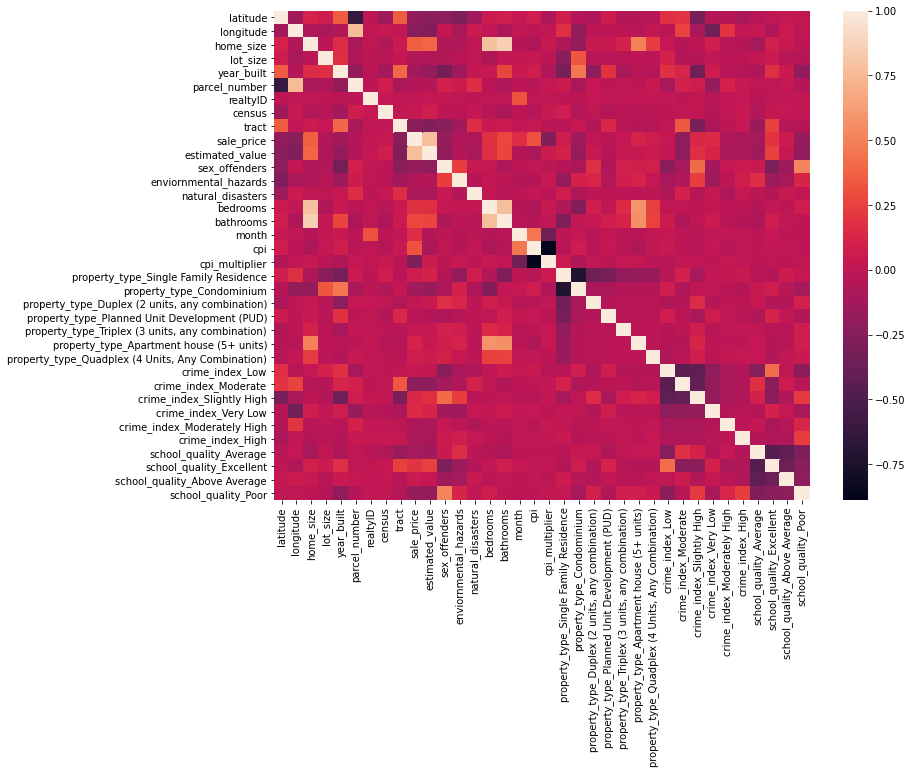

In [18]:
corrmat = temp.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat);

In [194]:
def correlation(dataset, threshold):
    
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    
    return col_corr


corr_features = correlation(df_trimmed, 0.6)
print('correlated features: ', len(set(corr_features)))
print(corr_features)

correlated features:  5
{'parcel_number', 'estimated_value', 'cpi_multiplier', 'bathrooms', 'bedrooms'}


In [105]:
def diagnostic_plots(df, variable, labels):
  
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    df[variable].hist()
    
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist='norm', plot=pylab)
    plt.title(col)
    
    plt.subplot(1,3,3)
    plt.scatter(df[variable], labels)
    plt.title(col)

In [19]:
#Let's examine crime index
temp = pd.concat([df_trimmed.groupby('crime_index')['sale_price'].mean(), df_trimmed.groupby('crime_index')['sale_price'].count()], axis=1)
temp.columns = ['Average sale price', 'Count of crime index type']
temp.sort_values(by='Average sale price', ascending=False)

,Average sale price,Count of crime index type
crime_index,,
Very Low,951997.08491,318
Slightly High,846369.10252,1073
Low,775122.06699,1224
Moderate,626972.37031,1145
Moderately High,542304.87805,82
High,453159.57447,47


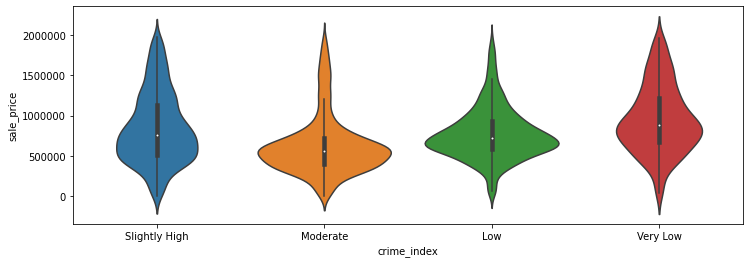

In [20]:
order=['Slightly High', 'Moderate', 'Low', 'Very Low']
filtered_df = df_trimmed.loc[((df_trimmed['crime_index']!='High') & (df_trimmed['crime_index']!='Moderately High'))]

plt.figure(figsize=(12,4))
sns.violinplot(x='crime_index', y='sale_price', data=filtered_df, order=order)
plt.ticklabel_format(style='plain', axis='y')

In [21]:
#Let's examine school quality
temp = pd.concat([df_trimmed.groupby('school_quality')['sale_price'].mean(), df_trimmed.groupby('school_quality')['sale_price'].count()], axis=1)
temp.columns = ['Average sale price', 'Count of school_quality types']
temp.sort_values(by='Average sale price', ascending=False)

,Average sale price,Count of school_quality types
school_quality,,
Excellent,879548.32666,1099
Above Average,793416.25402,933
Average,698907.28177,1377
Poor,570860.60625,480


In [22]:
#Lets remove the features that won't be needed for the model
drop_features = ['address', 'year_built', 'parcel_number', 'realtyID', 'county', 'subdivision',
                 'census', 'tract', 'lot', 'zoning', 'date', 'estimated_value', 'url', 'observation_date']

final_df = df_trimmed.drop(drop_features, axis=1)

In [58]:
#df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
#df.index.freq = 'D'
#df.index

In [23]:
final_df.to_csv('Data/house_data_details_eda.csv', index=False)